In [2]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import torchvision
import torch.nn as nn
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches
import os

In [3]:

def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 2
    elif obj.find('name').text == "mask_weared_incorrect":
        return 3
    return 1

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')
        num_objs = len(objects)
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        img_id = torch.tensor([image_id])
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target


In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [5]:
imgs = list(sorted(os.listdir("/content/gdrive/MyDrive/images")))


In [6]:
labels = list(sorted(os.listdir("/content/gdrive/MyDrive/annotations")))

In [7]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir("/content/gdrive/MyDrive/images")))
        self.labels = list(sorted(os.listdir("/content/gdrive/MyDrive/annotations")))

    def __getitem__(self, idx):
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join("/content/gdrive/MyDrive/images/", file_image)
        label_path = os.path.join("/content/gdrive/MyDrive/annotations/", file_label)
        img = Image.open(img_path).convert("RGB")
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [8]:
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

In [9]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform)
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=1, collate_fn=collate_fn)

In [10]:
torch.cuda.is_available()

True

# Model

In [11]:
def model_detection(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [12]:
model = model_detection(4)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{q: w.to(device) for q, w in n.items()} for n in annotations]
    break

# Train Model

In [14]:
num_epochs = 100
model.to(device)

parameter = [p for p in model.parameters() if p.requires_grad]
opt = torch.optim.SGD(parameter, lr=0.001, momentum=0.9, weight_decay=0.0005, nesterov=True)
history = []

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{q: w.to(device) for q, w in n.items()} for n in annotations]
        loss_dt = model([imgs[0]], [annotations[0]])
        loss = sum(los for los in loss_dt.values())   

        opt.zero_grad()
        loss.backward()
        opt.step()
        if epoch == 0:
          print(f'Iteration: {i}/{(len(data_loader))}, Loss: {loss}')
        epoch_loss += loss
    history.append(epoch_loss/i)
    print(f'epoch: {epoch} loss: {epoch_loss/i}')


Iteration: 1/853, Loss: 2.1639506816864014
Iteration: 2/853, Loss: 1.9320931434631348
Iteration: 3/853, Loss: 1.411953330039978
Iteration: 4/853, Loss: 1.230116605758667
Iteration: 5/853, Loss: 0.6881465315818787
Iteration: 6/853, Loss: 0.6582794785499573
Iteration: 7/853, Loss: 0.3940836787223816
Iteration: 8/853, Loss: 0.9558240175247192
Iteration: 9/853, Loss: 0.36873888969421387
Iteration: 10/853, Loss: 0.8364211916923523
Iteration: 11/853, Loss: 0.40886378288269043
Iteration: 12/853, Loss: 2.2293148040771484
Iteration: 13/853, Loss: 1.534742832183838
Iteration: 14/853, Loss: 0.9152151346206665
Iteration: 15/853, Loss: 0.25600093603134155
Iteration: 16/853, Loss: 0.4294350743293762
Iteration: 17/853, Loss: 0.29137900471687317
Iteration: 18/853, Loss: 0.40242254734039307
Iteration: 19/853, Loss: 0.555403470993042
Iteration: 20/853, Loss: 1.1718177795410156
Iteration: 21/853, Loss: 0.3869396448135376
Iteration: 22/853, Loss: 1.005159854888916
Iteration: 23/853, Loss: 0.26509577035903

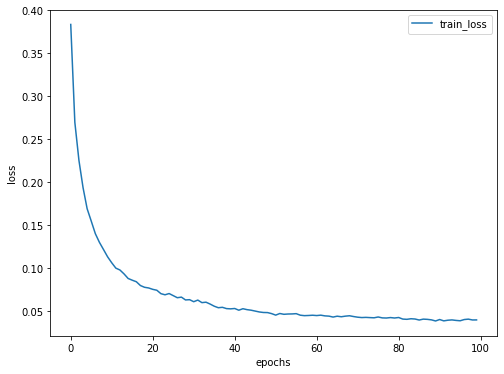

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(history, label="train_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [303]:
i=0
for imgs, annotations in data_loader:
        i+=1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{q: w.to(device) for q, w in n.items()} for n in annotations]
        if i == 30:
          break

In [304]:
model.eval()
predict = model(imgs)

# Function to plot image

In [305]:
def plot_image(img_tensor, annotation):
  fig,ax = plt.subplots(1, figsize=(8, 8))
  img = img_tensor.cpu().data
  ax.imshow(img.permute(1, 2, 0))

  dict_class = {1: 'no mask', 2: 'mask', 3: 'inc mask'}
  dict_color = {1: 'r', 2: 'g', 3: 'b'}
  spisok = [1, 2, 3]
  k = 0
  for box in annotation["boxes"]:
    xmin, ymin, xmax, ymax = box
    clas = 'None'
    for i in range(3):
      if int(annotation["labels"][k]) == spisok[i]:
        try:
          clas = dict_class[i+1] + ':' + str(round(float(annotation["scores"][k]),2))
          rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor=dict_color[i+1],facecolor='none')
        except:
          clas = dict_class[i+1]
          rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor=dict_color[i+1],facecolor='none')

    if clas != 'None':
      plt.text(xmax, ymax, f'{clas}', size=((xmax-xmin)/(((img.shape)[2])))*80, rotation=0.,
      ha="right", va="top",
      bbox=dict(boxstyle="square",
                ec=(1., 0.5, 0.5),
                fc=(1., 0.8, 0.8),
               )
      )
    ax.add_patch(rect)
    k += 1 

In [306]:
def area_boxes(boxA, boxB):
  xA = max(float(boxA[0]), float(boxB[0]))
  yA = max(float(boxA[1]), float(boxB[1]))
  xB = min(float(boxA[2]), float(boxB[2]))
  yB = min(float(boxA[3]), float(boxB[3]))
  interArea = abs(max(0, xB - xA) * max(0, yB - yA))
  if interArea == 0:
    iou = 0                                                                                                                           
  boxAArea = abs((float(boxA[2]) - float(boxA[0])) * (float(boxA[3]) - float(boxA[1])))
  boxBArea = abs((float(boxB[2]) - float(boxB[0])) * (float(boxB[3]) - float(boxB[1])))                                                                                                
  iou = interArea / (boxAArea + boxBArea - interArea)                                                                     
  return iou

In [307]:
def choose(preds_old, area_boxes):
  new_preds = {'boxes': [],'labels': [],'scores': []}
  preds = {'boxes': [],'labels': [],'scores': []}
  for i in range(len(preds_old['boxes'])):
    if preds_old['scores'][i] > 0.2:
      preds['boxes'].append(list(int(box) for box in preds_old['boxes'][i]))
      preds['labels'].append(int(preds_old['labels'][i]))
      preds['scores'].append(float(preds_old['scores'][i]))
  for i in range(len(preds['boxes'])):
    max_probability = preds['scores'][i]
    ind = i
    for j in range(len(preds['boxes'])):
      if area_boxes(preds['boxes'][i], preds['boxes'][j]) > 0.3 and preds['scores'][j] > max_probability:
        max_probability = preds['scores'][j]
        ind = j
      else:
        ind = ind
    if list(int(box) for box in preds['boxes'][ind]) not in new_preds['boxes']:
      new_preds['boxes'].append(list(int(box) for box in preds['boxes'][ind]))
      new_preds['labels'].append(int(preds['labels'][ind]))
      new_preds['scores'].append(float(preds['scores'][ind]))
  return new_preds

Prediction
Target


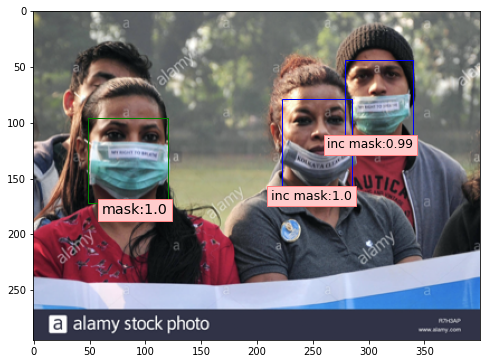

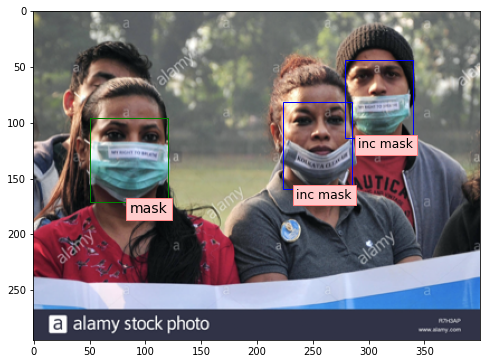

In [308]:
print("Prediction")
plot_image(imgs[0], choose(predict[0], area_boxes))
print("Target")
plot_image(imgs[0], annotations[0])


# Uploading your own images

In [316]:
class Own_images(object):
    def __init__(self, transforms, filename):
        self.transforms = transforms
        self.filename = filename

    def __getitem__(self, idx):
        img_path = os.path.join("/content/gdrive/MyDrive/test_images/", self.filename)
        img = Image.open(img_path).convert("RGB")
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img

    def __len__(self):
        return len(self.imgs)

In [317]:
dataset_test = Own_images(data_transform,  'orig.jfif')
own_img = [dataset_test[0]]
own_img = list(img.to(device) for img in own_img)
model.eval()
preds = model(own_img)

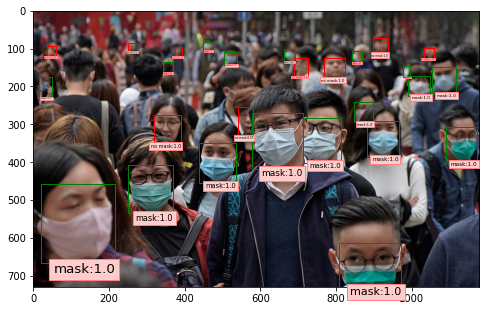

In [318]:
plot_image(own_img[0], choose(preds[0], area_boxes))

# Load model

In [288]:
torch.save(model.state_dict(),'model.pt')

In [289]:
model2 = model_detection(4)

In [313]:
model2.load_state_dict(torch.load('model.pt'))
model2.eval()
model2.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [314]:
predict2 = model2(imgs)

Predict with loaded model


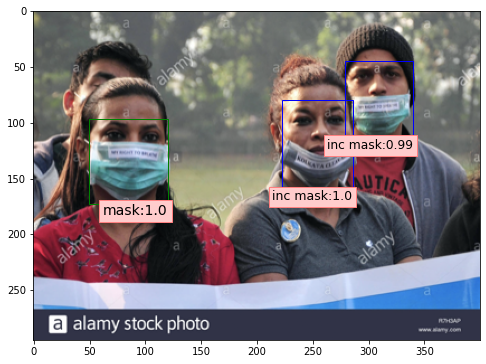

In [315]:
print("Predict with loaded model")
plot_image(imgs[0], predict2[0])